# Macro III - Problem Set 04 - Hopenhayn Model

Vinícius de Almeida Nery Ferreira

October 4th, 2024

In [1]:
# Importing packages
## Data
import numpy as np
import pandas as pd

## Plots
import matplotlib.pyplot as plt
plt.style.use('bmh')

## Other
import random
import time
from tqdm import tqdm
from numba import njit  # makes things faster

## Methods
from scipy.optimize import fsolve
from quantecon.markov.approximation import rouwenhorst, tauchen

# Setting seeds for random
random.seed(121019)
np.random.seed(121019)

In [2]:
# Ignoring rouwenhorst warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

We will study the **Hopenhayn** model, which has heterogeneous *firms*.

On paying a fixed operating cost $\kappa > 0$, an incumbent firm that hires $n$ workers produces flow output $y = zn^\alpha$ with $0 < \alpha < 1$ where $z > 0$ is a firm-level productivity level. The productivity of an incumbent firm evolves according to an AR(1) in logs:

$$
\ln(z_{t+1}) = (1 - \rho) \ln(\bar{z}) + \rho \ln(z_t) + \sigma \epsilon_{t+1}, \quad \rho \in (0,1), \, \sigma > 0
$$

where $\epsilon_{t+1} \sim N(0,1)$. 
Firms discount flow profits according to a constant discount factor $0 < \beta < 1$. 

There is an unlimited number of potential entrants. 
On paying a sunk entry cost $\kappa_e > 0$, an entrant receives an initial productivity draw $z_0 > 0$ and then starts operating the next period as an incumbent firm. 

For simplicity, assume that initial productivity $z_0$ is drawn from the stationary productivity distribution implied by the AR(1) above.

Individual firms take the price $p$ of their output as given. Industry-wide demand is given by:

$$
D(p) = \frac{\bar{D}}{p}

$$

for some constant $\bar{D} > 0$. 

Let labor be the numeraire, so that the wage is $w = 1$. 

Let $\pi(z)$ and $v(z)$ denote respectively the profit function and value function of a firm with productivity $z$. 

Let $v_e$ denote the corresponding expected value of an entering firm. 

Let $\mu(z)$ denote the (stationary) distribution of firms and let $m$ denote the associated measure of entering firms.

# (a) Profit Function

## Incumbent

### Profit

The profit function of the incumbent firm is

$$
\pi(z, p) = \max_n \left\{ p \cdot z n^{\alpha} - wn - \kappa \right\}
\tag{Profit}
$$

This gives the usual FOC that wage has to equal marginal productivity of labor:

$$
w = \alpha p z n^{\alpha - 1}
\quad \therefore \quad
n(z, p) = \left( \frac{\alpha p z}{w} \right)^{\frac{1}{1 - \alpha}}
$$

Note that, for two firms $i$ and $j$,

$$
\frac{n(z_j, p)}{n(z_i, p)} = \left( \frac{z_j}{z_i} \right)^{\frac{1}{1 - \alpha}}
$$

Thus, once $\alpha$ is known, the size distribution identifies the productivity distribution.

Finally, note that $\frac{\partial \pi(z, p)}{\partial z} = p n^\alpha \geq 0$.

### Exit Decision

In this model, firms can decide to exit the market after observing the shock.

Normalizing the value of exit to zero (and assuming they can't rejoin the market afterwards), we can write the Bellman Equation as

$$
V(z, p) = \pi(z, p) + \frac{1}{1 + r} \max \left\{ \int_{\mathbf{Z}} V(z', p) \Gamma(dz', z), 0 \right\}
\tag{Incumbent Bellman}
$$

where $z \in \mathbf{Z}$ are the possible values for firm-level idiosyncratic productivity shocks and $\Gamma(z', z)$ is the transition matrix associated with the Markov process.

Note that, since $\pi(z, p)$ is increasing in $z$, so is $V(z, p)$.
Thus, the exit decision comes down to a reservation rule.

Letting $\chi(z, p)$ be a indicator variable that denotes exit, we have that

$$
\chi(z, p) = 
\begin{cases}
1, \quad z < z^* \\
0, \quad z \geq z^*
\end{cases}
$$

## Entrant

Entrants firm pay fixed costs $\kappa_e$ and then draws its initial productivity distribution $z_0$ from the distribution $G(d z_0)$, where $G$ is the stationary distribution of the Markov chain associated with the AR(1) process in our case.

We can then write the value function as

$$
V^e(z_0, p) = -\kappa_e + \frac{1}{1 + r} \int_{\mathbf{Z}} V(z_0, p) G(d z_0)
\tag{Bellman Entrant}
$$

Since we are assuming free-entry, firms continue to entry until $V^e(z_0, p) = 0$.
Let $m$ denote the (endogenous) measure of entrant plants.

## Equilibrium

A ***stationary recursive competitive*** equilibrium iis a list of: firms decision rules $\{n(z,p), \chi(z,p)\}$, value functions $\{V(z,p), V^e(p)\}$, price $p$, an invariant measure of incumbent firms $\lambda$ and a measure of entrant plants $m$, such that:

- Given $p$, $n(z,p)$ solves the static hiring decision (*Profit*).
- Given $p$, $\chi(z,p)$ solves the exit decision (*Bellman Incumbent*) of the incumbent firm, and $V(z,p)$ is the associated value function.
- Free entry: $\kappa_e = \frac{1}{1+r} \int_Z V(z', p) G(dz')$.
- The good market clears:

$$
D(p) = \int_Z z f(n(z,p)) \lambda(dz,p)

$$

- The invariant measure of incumbent plants is given by:

$$
\lambda(z',p) = \int_Z \Gamma(z', z)[1 - \chi(z,p)] \lambda(dz,p) + m g(z')
$$

# (b) Solution

## Productivity Grid

First, we need to discretize the shock grid.
We will do so using Tauchen's method, as $\rho \leq 0.9$ and, theoretically, it can still provide a good approximation to the process.

Note that, to match Tiago's results, we have to use Tauchen's with three standard deviations of span (default of *quantecon*).

Furthermore, results using Tauchen's are prettier: Rouwenhorst's discretizes the grid to employment values that are very large, and so results look a little bit distorted.

### Discretization

In [3]:
# Defining parameters
## AR(1) parameters
mu = 1.4
rho = .9
variance_error = 0.2 ** 2

## Grid length
num_shocks = 33

In [4]:
# Tauchen to discretize the AR1 of log shock
discrete_ln_shock = tauchen(
    n=num_shocks, 
    rho=rho, 
    sigma=variance_error**(1 / 2), 
    mu=mu * (1 - rho)
)

In [5]:
# Getting state grid and transition matrix of ln(z)
state_grid_ln_shock = discrete_ln_shock.state_values
state_grid_shock = np.exp(state_grid_ln_shock)
transition_matrix = discrete_ln_shock.P

In [6]:
# Printing values for each state
print("Values for productivity (in level, not log):")
print(np.around(state_grid_shock, 3))

Values for productivity (in level, not log):
[ 1.024  1.116  1.216  1.325  1.444  1.574  1.715  1.87   2.038  2.221
  2.42   2.638  2.874  3.133  3.414  3.721  4.055  4.42   4.817  5.249
  5.721  6.235  6.795  7.405  8.071  8.796  9.586 10.447 11.386 12.409
 13.524 14.739 16.063]


In [7]:
# Printing transition matrix
print(np.around(transition_matrix, 3))

[[0.318 0.165 0.168 ... 0.    0.    0.   ]
 [0.195 0.139 0.166 ... 0.    0.    0.   ]
 [0.106 0.101 0.142 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.142 0.101 0.106]
 [0.    0.    0.    ... 0.166 0.139 0.195]
 [0.    0.    0.    ... 0.168 0.165 0.318]]


### Stationary Distribution

To calculate the stationary distribution of the process, we basically have to find the eigenvector associated with the transition matrix.
We can also do it via simulation, which is what we will do.

In [8]:
def get_stationary_distribution_shocks(transition_matrix, max_iter=10_000, tol=1e-12):
    # Dimensions
    num_shocks = transition_matrix.shape[0]

    # Guess for initial distribution
    v = np.ones(num_shocks) / num_shocks

    # Iterating until we converge to the stationary distribution
    for num_iter in range(max_iter):
        # New distribution
        ## v by default is a column vector, not a row: instead of computing vP = v as in slides,
        ## we calculate P'v' = v', where v is the row vector in slides (v': column)
        v_new = transition_matrix.T @ v

        # Checking sup norm
        if np.max(np.abs(v - v_new)) < tol:
            print(f"Converged in {num_iter} iterations.")
            return v_new
        else:
            v = v_new.copy()

In [9]:
# Calculating stationary distribution
stationary_dist_shocks = get_stationary_distribution_shocks(transition_matrix)

# Printing
print("\nStationary distribution of shocks:")
print(np.around(stationary_dist_shocks, 3))

Converged in 107 iterations.

Stationary distribution of shocks:
[0.001 0.001 0.002 0.004 0.006 0.009 0.013 0.018 0.025 0.032 0.04  0.048
 0.056 0.064 0.069 0.073 0.074 0.073 0.069 0.064 0.056 0.048 0.04  0.032
 0.025 0.018 0.013 0.009 0.006 0.004 0.002 0.001 0.001]


By assumption, this is the distribution that entrants drawn from.

In [10]:
# Creating object for better naming
entrant_productivity_distribution = stationary_dist_shocks.copy()

## Value Function Iteration

We now use VFI to iterate until convergence of the incumbent's value function.

### Parameters

Here, we define $\beta \coloneqq \frac{1}{1 + r}$.

In [11]:
# Defining parameters
## Structural
alpha = 2 / 3
beta = .8
kappa = 20
kappa_entrant = 40
tau = 0

## Demand
demand_constant = 100
demand_constant_alt = 120

In [12]:
# Storing r just in case
r_value = 1 / beta - 1

In [13]:
# Dictionaries for parameters
param_dict = {
    'alpha': alpha,
    'beta': beta,
    'kappa': kappa,
    'tau': tau,
    'kappa_entrant': kappa_entrant,
    'demand_constant': demand_constant
}

param_dict_alt = {
    'alpha': alpha,
    'beta': beta,
    'kappa': kappa,
    'tau': tau, 
    'kappa_entrant': kappa_entrant,
    'demand_constant': demand_constant_alt
}

### Profit and FOC

Recall that we are establishing $w$ as the numeraire, so $w = 1$.

In [14]:
def labor_profit_foc(p, z, param_dict):
    """ 
    Calculates the labor demand that solves the FOC of the profit maximization problem.
    """

    # Parameters
    alpha = param_dict['alpha']

    # Calculating n(z, p)
    n = (alpha * p * z)**(1 / (1 - alpha))
 
    return n

In [15]:
def get_output(z, n, param_dict):
    """ 
    Calculates firm output.
    """
    
    return z * n**param_dict['alpha']

In [16]:
def get_profit(p, z, param_dict):
    """ 
    Calculates the profit value function and the optimal number of employees.
    """
    
    # Parameters
    kappa = param_dict['kappa']

    # Labor
    n = labor_profit_foc(p=p, z=z, param_dict=param_dict)

    # Output
    output = get_output(z=z, n=n, param_dict=param_dict)

    # Profit
    profit = p * output - n - kappa

    return profit, n

### VFI and Exit Rule

In [17]:
def value_function_iteration_bellman(p, shock_space, shock_transition_matrix, 
                                     param_dict, outside_value=0,
                                     tol=1e-10, max_iter=5000):
    """
    Iterating through vectors (function approximations) until we reach a fixed point conditional on all shocks.
    """

    # Parameters
    beta = param_dict['beta']

    # Assuring spaces are arrays
    shock_space = np.array(shock_space)

    # Calculating the firm's profit and hiring decision
    profit, n = get_profit(p=p, z=shock_space, param_dict=param_dict)

    # Initial guess for V: profit, without continuation value
    V = profit.copy()

    # Iterating
    for num_iter in range(max_iter):
        # Calculating expected value tomorrow: this a num_shocks x 1 vector, as V is num_shocks x 1
        expected_V_tomorrow = shock_transition_matrix @ V

        # New value function: recall firms can exit
        V_new = profit + beta * np.maximum(expected_V_tomorrow, outside_value)

        # Checking if we found the fixed point using the sup norm FOR EACH shock
        if np.max(np.abs(V - V_new)) < tol:
            break
        else:
            V = V_new.copy() 
    
    # Assessing convergence
    if num_iter >= max_iter - 1:
        print(f"Value function did not converge in {num_iter} iterations with tolerance {tol}.")

    return V_new, num_iter

In [18]:
# Test with dummy price
V_test, num_iter_vfi_test = value_function_iteration_bellman(
    p=2,
    shock_space=state_grid_shock,
    shock_transition_matrix=transition_matrix,
    param_dict=param_dict
)

In [19]:
def get_exit_rule(V, shock_space, shock_transition_matrix, outside_value=0):
    """ 
    Calculates the firm exit decision.
    """
    
    # Skeleton: the exit rule is conditional on the current state,
    # so it is a num_shocks x 1 vector, as is the value function
    chi = np.zeros(V.shape[0])

    # Firm decides to exit if the expected value is lower than the outside value
    chi[shock_transition_matrix @ V < outside_value] = 1

    # Finding productivity cut-off below which a firm exits (if = 0, is the first index where the firm does not exit)
    index_stays_in_market = np.where(chi == 0)[0][0]
    z_star = shock_space[index_stays_in_market - 1]

    return chi, z_star

## Free-Entry

Since we are assuming free-entry, firms continue to entry until $V^e(z_0, p) = 0$.
This implies

$$
\kappa_e = \beta \int_{\mathbf{Z}} V(z_0, p) G(d z_0),
$$

where $G(\cdot)$ is the stationary shock distribution in our case.

We need to iterate in $p$ until the free-entry condition is satisfied. For that, we will use our good friend *fsolve*.

In [20]:
def check_free_entry(V, entrant_distribution, param_dict):
    """
    Calculates the value of the entrant firm and checks the free-entry condition.
    """

    # Parameters
    kappa_entrant = param_dict['kappa_entrant']
    beta = param_dict['beta']

    # Calculating the value of entrant firm
    ## Note that we approximating \int_Z with the sum
    V_entrant = -kappa_entrant + beta * np.sum(V * entrant_distribution)

    return V_entrant

## Measure of Entrants and Stationary Distribution

In [21]:
@njit
def get_invariant_measure_incumbent(m, shock_transition_matrix, 
                                    exit_rule, entrant_distribution,
                                    max_iter=10_000, tol=1e-12):
    """ 
    Given the guess of the measure of entrants, finds the 
    stationary measure of incumbent firms.
    """

    # Dimensions
    num_shocks = shock_transition_matrix.shape[0]

    # Skeletons and initial guess
    incumbent_distribution = entrant_distribution.copy()

    # Transition matrix of incumbents: only those with  z > z* keep operating
    # Recall that states today are in the rows and tomorrow in the columns
    ## Skeleton
    incumbent_transition_matrix = shock_transition_matrix.copy()
    
    ## Looping to enforce the decision rule
    for index_shock_today in range(num_shocks):
        incumbent_transition_matrix[index_shock_today, :] = \
            incumbent_transition_matrix[index_shock_today, :] * (1 - exit_rule[index_shock_today])

    # Iterating
    for num_iter in range(max_iter):
        # Calculating new distribution: see Martinez's slides for explanation
        incumbent_distribution_new = incumbent_distribution.T @ incumbent_transition_matrix
        incumbent_distribution_new = incumbent_distribution_new.T
        incumbent_distribution_new += m * entrant_distribution

        # incumbent_distribution_new = \
        #    incumbent_transition_matrix.T @ incumbent_distribution \
        #        + m * entrant_distribution
    
        # Checking sup norm
        if np.max(np.abs(incumbent_distribution - incumbent_distribution_new)) < tol:
            break        
        else:
            incumbent_distribution = incumbent_distribution_new.copy()
   
   # Assessing convergence
    if num_iter >= max_iter - 1:
        print(f"Distribution function did not converge in {max_iter} iterations.")
    
    return incumbent_distribution_new, incumbent_transition_matrix

## Goods Market Clearing

In [22]:
def get_demand(p, param_dict):
    return param_dict['demand_constant'] / p

In [23]:
def get_supply(output, incumbent_distribution):
    return np.sum(output * incumbent_distribution)

## Solution

### Price

In [24]:
def find_price(p_guess, shock_space,
               shock_transition_matrix, entrant_distribution,
               param_dict, outside_value=0,
               tol_vfi=1e-9, max_iter_vfi=5000):
    """ 
    Finds the equilibrium price of Hopenhayn (1992) when
    passed to a root finder function.
    """

    # 1. Calculating the value of the incumbent firm
    V, num_iter_vfi = value_function_iteration_bellman(
        p=p_guess,
        shock_space=shock_space,
        shock_transition_matrix=shock_transition_matrix,
        param_dict=param_dict,
        outside_value=outside_value,
        max_iter=max_iter_vfi,
        tol=tol_vfi
    )

    # 2. Calculating the value of entrant firm
    V_entrant = check_free_entry(
        V=V,
        entrant_distribution=entrant_distribution,
        param_dict=param_dict
    )

    # Returning V_entrant, which is what we want to be zero
    return V_entrant

In [25]:
# Finding the equilibrium price with fsolve
hopenhayn_opt_price = fsolve(
    func=lambda p: find_price(
        p_guess=p,
        shock_space=state_grid_shock,
        shock_transition_matrix=transition_matrix,
        entrant_distribution=entrant_productivity_distribution,
        param_dict=param_dict
    ),
    x0=1,
    full_output=True
)

In [26]:
# Printing solution
p_market_clearing = hopenhayn_opt_price[0][0]
num_iter_market = hopenhayn_opt_price[1]['nfev']

print(f"Free-entry price: {round(p_market_clearing, 6)}.")
print(f"Iterations of fsolve: {num_iter_market}.")

Free-entry price: 1.004135.
Iterations of fsolve: 6.


With Tauchen's, we get a price of $p = 1.00413$, which is the same as Tiago's.

In [27]:
# Value functions and exit rules
## Value
V, num_iter_vfi = value_function_iteration_bellman(
    p=p_market_clearing,
    shock_space=state_grid_shock,
    shock_transition_matrix=transition_matrix,
    param_dict=param_dict
)

## Exit rule
chi, z_star = get_exit_rule(
    V=V,
    shock_space=state_grid_shock,
    shock_transition_matrix=transition_matrix
)

## Productivity cut-off
print(f"z* = {round(z_star, 2)}")

z* = 3.72


With Tauchen's, we get $z^* = 3.72$, which is the same as Tiago's.

In [28]:
# Profit and optimal labor for each state
profit, n = get_profit(p=p_market_clearing, z=state_grid_shock, param_dict=param_dict)

# Output of each state
output = get_output(n=n, z=state_grid_shock, param_dict=param_dict)

### Entrants

In [29]:
def find_measure_entrants(m_guess, p, shock_space, shock_transition_matrix, 
                          exit_rule, entrant_distribution,
                          param_dict, max_iter_dist=10_000, tol_dist=1e-12):
    """ 
    Finds the equilibrium measure of entrants m of Hopenhayn (1992) 
    when passed to a root finder function.
    """

    # 1. Calculating the invariant incumbent distribution given m
    incumbent_distribution, incumbent_transition_matrix = get_invariant_measure_incumbent(
        m=m_guess,
        shock_transition_matrix=shock_transition_matrix,
        exit_rule=exit_rule,
        entrant_distribution=entrant_distribution,
        max_iter=max_iter_dist,
        tol=tol_dist
    )

    # 2. Getting demand and supply
    ## Demand
    demand = get_demand(p=p, param_dict=param_dict)

    ## Supply
    profit, n = get_profit(p=p, z=shock_space, param_dict=param_dict)
    output = get_output(n=n, z=shock_space, param_dict=param_dict)

    supply = get_supply(output=output, incumbent_distribution=incumbent_distribution)

    # 3. Returning excess demand
    return demand - supply

In [30]:
# Finding the equilibrium measure of entrantes with fsolve
hopenhayn_opt_measure = fsolve(
    func=lambda m: find_measure_entrants(
        m_guess=m, 
        p=p_market_clearing,
        shock_space=state_grid_shock,
        shock_transition_matrix=transition_matrix,
        exit_rule=chi,
        entrant_distribution=entrant_productivity_distribution,
        param_dict=param_dict
    ),
    x0=0.5,
    full_output=True
)

In [31]:
# Printing solution
m_market_clearing = hopenhayn_opt_measure[0][0]
num_iter_measure = hopenhayn_opt_measure[1]['nfev']

print(f"Market Clearing Measure of Entrants: {round(m_market_clearing, 6)}.")
print(f"Iterations of fsolve: {num_iter_measure}.")

Market Clearing Measure of Entrants: 0.089389.
Iterations of fsolve: 4.


With Tauchen's, we get $m = 0.0893$, which is the same as Tiago's.

## Distributions

### Firms and Productivity

In [31]:
# Getting invariant distribution of firms
stationary_incumbent_distribution, incumbent_transition_matrix = get_invariant_measure_incumbent(
    m=m_market_clearing,
    shock_transition_matrix=transition_matrix,
    exit_rule=chi,
    entrant_distribution=entrant_productivity_distribution
)

# This distribution doesn't sum to 1: we have to normalize it
stationary_incumbent_distribution = stationary_incumbent_distribution \
    / np.sum(stationary_incumbent_distribution)

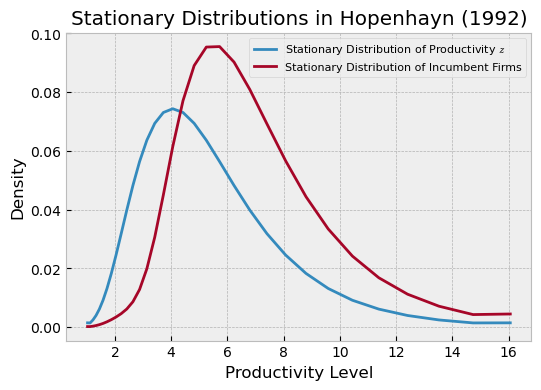

In [32]:
# Plotting invariant distributions of productivity and incumbent firms
plt.figure(figsize=(6, 4))
plt.plot(state_grid_shock, stationary_dist_shocks, 
         label=fr'Stationary Distribution of Productivity $z$')

plt.plot(state_grid_shock, stationary_incumbent_distribution, 
         label=fr'Stationary Distribution of Incumbent Firms')

# Adding labels and title
plt.title('Stationary Distributions in Hopenhayn (1992)')
plt.xlabel('Productivity Level')
plt.ylabel('Density')
plt.legend(loc='upper right', fontsize=8)

# Show the plot
plt.show()

We see that the (endogenous) distribution of firms is shifted to the right due to existence of sunk costs of entry ($\kappa_e$) and of operation ($\kappa$).

For this reason, only firms that are more productive enter the market and stay in it.

### Employment

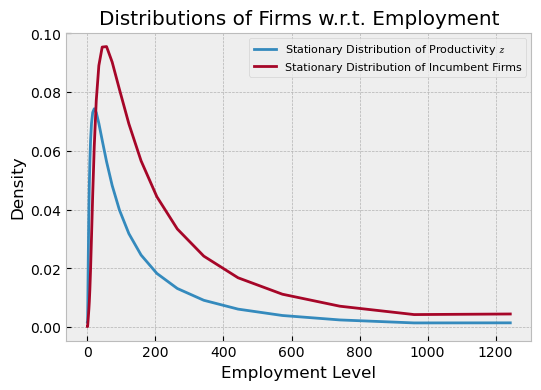

In [33]:
# Plotting invariant distributions of employment by firm size
plt.figure(figsize=(6, 4))

plt.plot(n, stationary_dist_shocks, 
         label=fr'Stationary Distribution of Productivity $z$')

plt.plot(n, stationary_incumbent_distribution,
         label=fr'Stationary Distribution of Incumbent Firms')

# Adding labels and title
plt.title('Distributions of Firms w.r.t. Employment')
plt.xlabel('Employment Level')
plt.ylabel('Density')
plt.legend(loc='upper right', fontsize=8)

# Show the plot
plt.show()

Again, the stationary distribution of firms is shifted to the right: only more productive firms enter and stay in the market, which are the ones that hire more.

In [34]:
# Calculating employment distribution
stationary_n_distribution = stationary_incumbent_distribution * n
stationary_n_distribution = stationary_n_distribution / np.sum(stationary_n_distribution)

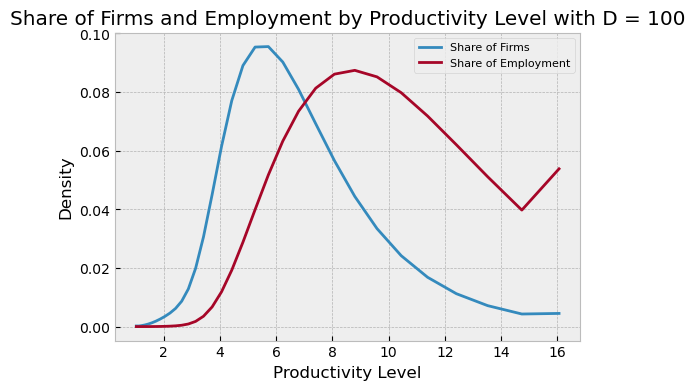

In [35]:
# Plotting distributions of firms and employment
plt.figure(figsize=(6, 4))

plt.plot(state_grid_shock, stationary_incumbent_distribution, 
         label=fr'Share of Firms')

plt.plot(state_grid_shock, stationary_n_distribution, 
         label=fr'Share of Employment')

# Adding labels and title
plt.title(f'Share of Firms and Employment by Productivity Level with D = {param_dict["demand_constant"]}')
plt.xlabel('Productivity Level')
plt.ylabel('Density')
plt.legend(loc='upper right', fontsize=8)

# Show the plot
plt.show()

Finally, we see that the bigger firms - which are less numerous - represent a bigger part of aggregate employment.

# (c) Increase in Demand

## Solution

### Price

In [36]:
# Finding the equilibrium price with fsolve
hopenhayn_opt_price_alt = fsolve(
    func=lambda p: find_price(
        p_guess=p,
        shock_space=state_grid_shock,
        shock_transition_matrix=transition_matrix,
        entrant_distribution=entrant_productivity_distribution,
        param_dict=param_dict_alt
    ),
    x0=1,
    full_output=True
)

In [37]:
# Printing solution
p_market_clearing_alt = hopenhayn_opt_price_alt[0][0]
num_iter_market_alt = hopenhayn_opt_price_alt[1]['nfev']

print(f"Free-entry price with D = {param_dict['demand_constant']}: {round(p_market_clearing, 6)}.")
print(f"Free-entry price with D = {param_dict_alt['demand_constant']}: {round(p_market_clearing_alt, 6)}.")

Free-entry price with D = 100: 1.004135.
Free-entry price with D = 120: 1.004135.


Note that the price **doesn't change**. 

Indeed, price determination has nothing to do it with demand, but rather with the free-entry condition of firms.

In [38]:
# Value functions and exit rules
## Value
V_alt, num_iter_vfi_alt = value_function_iteration_bellman(
    p=p_market_clearing_alt,
    shock_space=state_grid_shock,
    shock_transition_matrix=transition_matrix,
    param_dict=param_dict_alt
)

## Exit rule
chi_alt, z_star_alt = get_exit_rule(
    V=V_alt,
    shock_space=state_grid_shock,
    shock_transition_matrix=transition_matrix
)

## Productivity cut-off
print(f"z* = {round(z_star_alt, 2)}")

z* = 3.72


In [39]:
# Profit and optimal labor for each state
profit_alt, n_alt = get_profit(p=p_market_clearing_alt, z=state_grid_shock,
                               param_dict=param_dict_alt)

# Output of each state
output_alt = get_output(n=n_alt, z=state_grid_shock, 
                        param_dict=param_dict_alt)

### Entrants

In [40]:
# Finding the equilibrium measure of entrantes with fsolve
hopenhayn_opt_measure_alt = fsolve(
    func=lambda m: find_measure_entrants(
        m_guess=m, 
        p=p_market_clearing_alt,
        shock_space=state_grid_shock,
        shock_transition_matrix=transition_matrix,
        exit_rule=chi_alt,
        entrant_distribution=entrant_productivity_distribution,
        param_dict=param_dict_alt
    ),
    x0=0.5,
    full_output=True
)

In [41]:
# Printing solution
m_market_clearing_alt = hopenhayn_opt_measure_alt[0][0]
num_iter_measure_alt = hopenhayn_opt_measure_alt[1]['nfev']

print(f"Market clearing measure of entrants with D = {param_dict['demand_constant']}: {round(m_market_clearing, 6)}.")
print(f"Market clearing measure of entrants with D = {param_dict_alt['demand_constant']}: {round(m_market_clearing_alt, 6)}.")

Market clearing measure of entrants with D = 100: 0.089389.
Market clearing measure of entrants with D = 120: 0.107267.


Note that $m$ is now **higher** with the increase in demand.

This is simply because the aggregate supply has to be bigger to meet the aggregate demand, which requires more firms.

## Distributions

### Firms and Productivity

In [42]:
# Getting invariant distribution of firms
stationary_incumbent_distribution_alt, incumbent_transition_matrix_alt = get_invariant_measure_incumbent(
    m=m_market_clearing_alt,
    shock_transition_matrix=transition_matrix,
    exit_rule=chi_alt,
    entrant_distribution=entrant_productivity_distribution
)

# This distribution doesn't sum to 1: we have to normalize it
stationary_incumbent_distribution_alt = stationary_incumbent_distribution_alt \
    / np.sum(stationary_incumbent_distribution_alt)

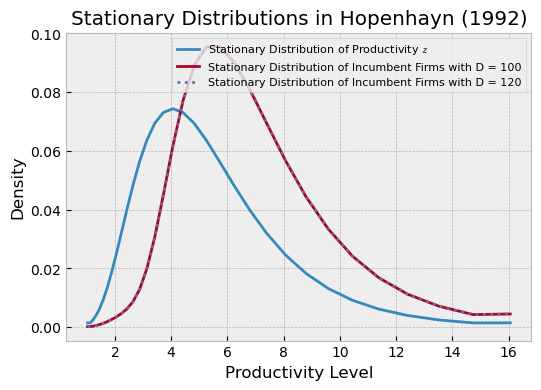

In [43]:
# Plotting invariant distributions of productivity and incumbent firms
plt.figure(figsize=(6, 4))
plt.plot(state_grid_shock, stationary_dist_shocks, 
         label=fr'Stationary Distribution of Productivity $z$')

plt.plot(state_grid_shock, stationary_incumbent_distribution, 
         label=fr'Stationary Distribution of Incumbent Firms with D = {param_dict["demand_constant"]}')

plt.plot(state_grid_shock, stationary_incumbent_distribution_alt, 
         linestyle='dotted',
         label=fr'Stationary Distribution of Incumbent Firms with D = {param_dict_alt["demand_constant"]}')

# Adding labels and title
plt.title('Stationary Distributions in Hopenhayn (1992)')
plt.xlabel('Productivity Level')
plt.ylabel('Density')
plt.legend(loc='upper right', fontsize=8)

# Show the plot
plt.show()

In [44]:
np.allclose(stationary_incumbent_distribution,
            stationary_incumbent_distribution_alt)

True

The distributions of firms are the same, despite the increase in the measure of entrants $m$.
Note also that $\chi$ is determined in the price-finding process, so it is also the same.

This is exactly because the parameters determining the firms' "survival" didn't change: we can have more entrants, but the distribution of those that stay in the economy are exactly the same.

### Employment

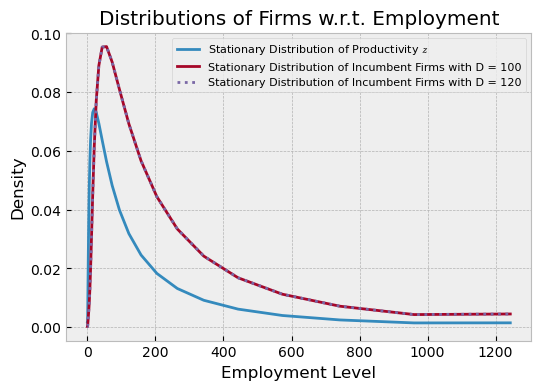

In [45]:
# Plotting invariant distributions of productivity and incumbent firms
plt.figure(figsize=(6, 4))
plt.plot(n, stationary_dist_shocks, 
         label=fr'Stationary Distribution of Productivity $z$')

plt.plot(n, stationary_incumbent_distribution, 
         label=fr'Stationary Distribution of Incumbent Firms with D = {param_dict["demand_constant"]}')

plt.plot(n_alt, stationary_incumbent_distribution_alt, 
         linestyle='dotted',
         label=fr'Stationary Distribution of Incumbent Firms with D = {param_dict_alt["demand_constant"]}')

# Adding labels and title
plt.title('Distributions of Firms w.r.t. Employment')
plt.xlabel('Employment Level')
plt.ylabel('Density')
plt.legend(loc='upper right', fontsize=8)

# Show the plot
plt.show()

Again, the distribution are the same: this is because $n(z, p)$ is determined in the price-finding process, and so does not depend on $m$.

In [46]:
# Calculating employment distribution
stationary_n_distribution_alt = stationary_incumbent_distribution_alt * n_alt
stationary_n_distribution_alt = stationary_n_distribution_alt / np.sum(stationary_n_distribution_alt)

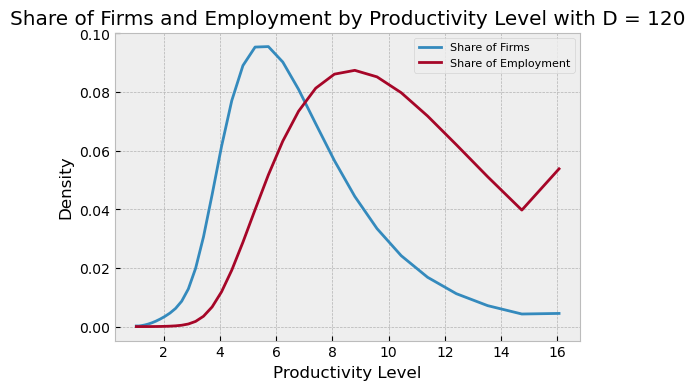

In [47]:
# Plotting distributions of firms and employment
plt.figure(figsize=(6, 4))

plt.plot(state_grid_shock, stationary_incumbent_distribution_alt, 
         label=fr'Share of Firms')

plt.plot(state_grid_shock, stationary_n_distribution_alt, 
         label=fr'Share of Employment')

# Adding labels and title
plt.title(f'Share of Firms and Employment by Productivity Level with D = {param_dict_alt["demand_constant"]}')
plt.xlabel('Productivity Level')
plt.ylabel('Density')
plt.legend(loc='upper right', fontsize=8)

# Show the plot
plt.show()

# (d) Firing Costs

## (a) Profit and Value Function

Following Hopenhayn and Rogerson (1993), we will introduce a firing cost $g$ such that

$$
g(n_t, n_{t-1}) =
\begin{cases}
\tau \cdot (n_{t - 1} - n_{t}), \quad & n_t < n_{t-1} \\
0, \quad & n_t \geq n_{t-1}
\end{cases}
$$

This can be expressed equivalently as

$$
g(n_t, n_{t-1}) = \tau \cdot \max \{ 0, n_{t - 1} - n_t \}
$$

Now, the employment choice is **dynamic**, with past employment being a state variable.

Thus, firms need to keep track of their past employment to calculate the firing cost $g$ associated with their new employment decision.

Firms don't decide employment by just maximizing profit anymore.
Their value function is now

$$
V(z, p; n_0) = 
\max_n \left\{ p \cdot z n^\alpha - wn - \kappa - g(n, n_0) \right\}
+ 
\beta \max \left\{ \int_{\mathbf{Z}} V(z', p; n) \Gamma(dz', z), -g(0, n) \right\}
$$

We make two observations: 

1. We don't make a general equilibrium model as Hopenhayn and Rogerson (1993), keeping the demand side as exogenous.

2. Note that the introduction of the firing cost does not change the problem of the entrant firm, only of the incumbent.
The only thing we have to keep in mind is that it starts with zero employees:

$$
V^e(z_0, p) = -\kappa_e + \frac{1}{1 + r} \int_{\mathbf{Z}} V(z_0, p; 0) G(d z_0)
$$

## (b) Solution

### Grid for Employment

(Past) Employment is now a state variable, so we need to make a grid for it.

In [48]:
# Seeing range of previous decisions
print(np.around(n, 0))

[0.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 2.000e+00
 2.000e+00 3.000e+00 3.000e+00 4.000e+00 6.000e+00 7.000e+00 9.000e+00
 1.200e+01 1.500e+01 2.000e+01 2.600e+01 3.400e+01 4.300e+01 5.600e+01
 7.300e+01 9.400e+01 1.220e+02 1.580e+02 2.040e+02 2.640e+02 3.420e+02
 4.430e+02 5.730e+02 7.420e+02 9.600e+02 1.243e+03]


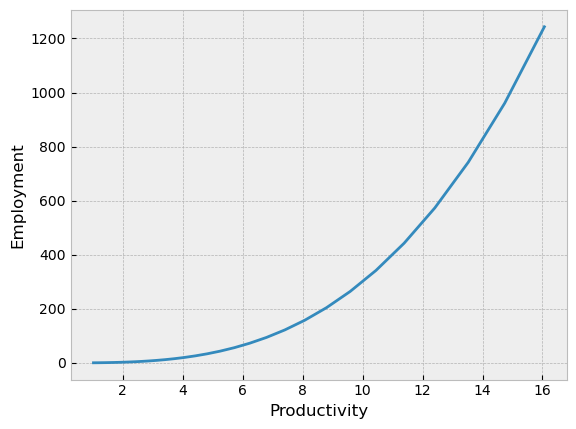

In [49]:
# Plotting
plt.plot(state_grid_shock, n, label='Previous Optimal Decision')

plt.xlabel('Productivity')
plt.ylabel('Employment')
plt.show()

It will be useful to determine a grid that is *not* linearly spaced.
We will use a double exponential grid.

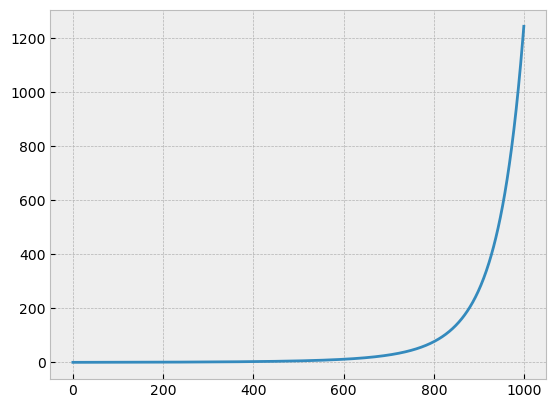

In [50]:
# Double exponential grid
## Number of states
num_states_employment = 1000

## Grid for u
u_max = np.log(1 + np.log(1 + n[-1] - 0))
u_grid = np.linspace(0, u_max, num_states_employment)

## Grid for a
# Double exponential transformation
employment_grid = 0 + np.exp(np.exp(u_grid) - 1) - 1
plt.plot(employment_grid)

### VFI

To solve the optimal decision, we have to find a policy function for $n = n(z, n_0)$.
We will do that using our standard VFI method from other notebooks.

#### Profit and Firing Cost Functions

In [51]:
def get_firing_cost(n_current, n_past, param_dict):
    """
    Calculates the asymmetric firing costs. 
    """

    # Parameters
    tau = param_dict['tau']

    # Calculating unconditional function
    cost = tau * (n_past - n_current)

    # Returning cost
    return np.maximum(0, cost)

In [52]:
def get_profit_firing_cost(p, z, n_current, n_past, param_dict):
    """ 
    Calculates the profit value function
    """

    # Parameters
    kappa = param_dict['kappa']

    # Output
    output = get_output(z=z, n=n_current, param_dict=param_dict)

    # Firing cost
    g = get_firing_cost(n_current=n_current, n_past=n_past, param_dict=param_dict)

    # Profit
    profit = p * output - n_current - kappa - g

    return profit

In [53]:
def get_profit_conditional_on_shock(n_past, n_current, p, z, param_dict):
    """
    Calculates profit matrices as a function of employment yesterday, today
    and parameters, conditional on each value of employment.
    Returns an array of matrices of profits for each possible combination of n_past, n_current and shock
    """
    
    # Number of shocks and capital states
    num_shocks = z.shape[0]
    num_states = n_past.shape[0]

    # Array
    conditional_profit_array = np.zeros([num_shocks, num_states, num_states])

    # Loop to fill arrays
    for index in range(num_shocks):
        # Calculating profits
        conditional_profit_array[index] = get_profit_firing_cost(
            p=p,
            n_past=n_past,
            n_current=n_current,
            z=z[index], 
            param_dict=param_dict
        ).T

    # Returning
    return conditional_profit_array

#### VFI Function

Importantly, the outside value is no longer zero, but rather the cost of firing everyone.

In [54]:
def value_function_iteration(p, n_space, shock_space, shock_transition_matrix,
                             param_dict, outside_value=0,
                             tol=1e-10, max_iter=5000):
    """
    Iterating through vectors (function approximations) until we reach a fixed point conditional on all shocks.
    """

    # Parameters
    beta = param_dict['beta']

    # Assuring spaces are arrays
    n_space = np.array(n_space)
    shock_space = np.array(shock_space)

    # Getting dimensions of matrices and vectors
    num_states = n_space.shape[0]
    num_shocks = shock_space.shape[0]

    # Initial guess
    V = np.zeros([num_shocks, num_states])
    V_new = np.zeros([num_shocks, num_states])

    ## Skeleton to store optimal indexes for policy function
    optimal_indexes = np.zeros([num_shocks, num_states])
    policy_n = np.zeros([num_shocks, num_states])

    # Creating meshgrid, which give coordinates of a and a'
    n_past_matrix, n_current_matrix = np.meshgrid(n_space, n_space)

    # Array with profits for each possible combination of n_past, n_current and shock value
    ## For each shock value (first dimension), returns a matrix of profits for employment today
    ## in rows (second dimension) and employment yesterday in columns (third dimension)
    profit_array_conditional_shock = get_profit_conditional_on_shock(
        n_past=n_past_matrix,
        n_current=n_current_matrix,
        p=p,
        z=shock_space,
        param_dict=param_dict
    )

    # Iterating
    for num_iter in range(max_iter):
        # Calculating matrix of possible values of V: for every state today (column),
        # what is the value of each state tomorrow (row) conditional on each shock

        ## Loop
        for index_shock in range(num_shocks):
            # Expected value tomorrow
            expected_V_tomorrow = shock_transition_matrix[[index_shock]] @ V

            # Transforming into a vector
            expected_V_tomorrow = expected_V_tomorrow[0, :]

            # Firm has the option to exit the market, but has to fire everyone
            ## Cost
            g0 = get_firing_cost(n_current=np.zeros(num_states), n_past=n_space, param_dict=param_dict)

            ## Calculating matrix of values
            ### Important: in numpy, operations between matrices (first term) and vectors (second term)
            ### are done column-wise. That is, we add B * V(a', z') to each column, which is exactly 
            ### what we want, as rows represent a' (see matrix on slide 27 of Lecture 4)
            matrix_state_values = profit_array_conditional_shock[index_shock] + \
                beta * np.maximum(expected_V_tomorrow, outside_value - g0)

            # Calculating maximum value for each state today (columns, axis=1)
            # That is, for each column, we are grabbing the row (next state) which maximizes V for that state
            # (conditional on the productivity shock we are on)
            # Keep
            V_new[index_shock] = np.max(matrix_state_values, axis=1)

            # Calculating index of maximum value (for policy function)
            optimal_indexes[index_shock] = np.argmax(matrix_state_values, axis=1)

        # Checking if we found the fixed point using the sup norm FOR EACH shock
        # That is, we want the loop to stop when all conditions are satisfied
        if np.max(np.abs(V - V_new)) < tol:
            break
        else:
            V = V_new.copy() 

    # Assessing convergence
    if num_iter >= max_iter - 1:
        print(f"Value function did not converge in {num_iter} iterations with tolerance {tol}.")

    # Calculating policy functions of assets and consumption conditional on each state today
    ## Transforming to integer
    optimal_indexes = optimal_indexes.astype(int)

    ## Looping across states
    for index_shock_today in range(num_shocks):
        policy_n[index_shock_today] = n_space[optimal_indexes[index_shock_today]]

    return V_new, policy_n, optimal_indexes, num_iter

In [55]:
# Test: with tau = 0, the policy function should 
# 1. Be constant within the same space
# 2. Be exactly of the static decision
V_test_fc, policy_n_test_fc, policy_n_indexes_test_fc, num_iter_test_fc = value_function_iteration(
    p=p_market_clearing,
    n_space=employment_grid,
    shock_space=state_grid_shock,
    shock_transition_matrix=transition_matrix,
    param_dict=param_dict
)

In [56]:
# Checking variance within same shock/productivity state: all zero, uhul!
for index_shock in range(policy_n_test_fc.shape[0]):
    print(f"Variance of shock state {index_shock}: {round(np.var(policy_n_test_fc[index_shock]), 10)}")

Variance of shock state 0: 0.0
Variance of shock state 1: 0.0
Variance of shock state 2: 0.0
Variance of shock state 3: 0.0
Variance of shock state 4: 0.0
Variance of shock state 5: 0.0
Variance of shock state 6: 0.0
Variance of shock state 7: 0.0
Variance of shock state 8: 0.0
Variance of shock state 9: 0.0
Variance of shock state 10: 0.0
Variance of shock state 11: 0.0
Variance of shock state 12: 0.0
Variance of shock state 13: 0.0
Variance of shock state 14: 0.0
Variance of shock state 15: 0.0
Variance of shock state 16: 0.0
Variance of shock state 17: 0.0
Variance of shock state 18: 0.0
Variance of shock state 19: 0.0
Variance of shock state 20: 0.0
Variance of shock state 21: 0.0
Variance of shock state 22: 0.0
Variance of shock state 23: 0.0
Variance of shock state 24: 0.0
Variance of shock state 25: 0.0
Variance of shock state 26: 0.0
Variance of shock state 27: 0.0
Variance of shock state 28: 0.0
Variance of shock state 29: 0.0
Variance of shock state 30: 0.0
Variance of shock 

[ 0.4  -0.48  0.01 -0.27  0.   -0.33 -0.3   0.28 -0.32  0.18  0.17  0.09
 -0.22 -0.12  0.39 -0.31  0.29 -0.36 -0.42  0.27 -0.23  0.24 -0.45  0.1
 -0.44  0.55  0.56 -0.45  0.47  0.49 -0.41 -0.62 -0.  ]


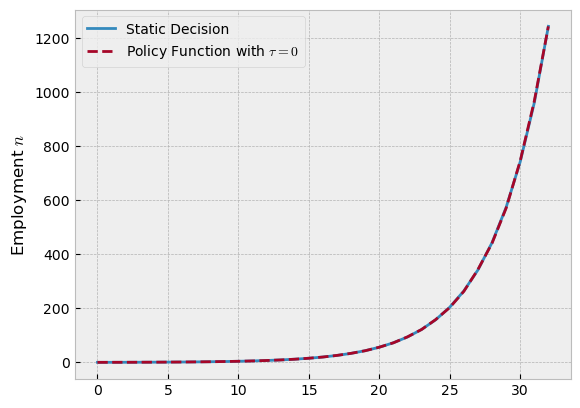

In [57]:
# All good: everything is constant
# Checking if the policy equals the static decision in all states (relative error)
# It won't be exactly the same because we are in a grid, but it has to be close
print(np.around(100 * (n - policy_n_test_fc[:, 0]) / n, 2))

# All errors are within 1%, and errors really come from the grid not being fine enough: all good!
plt.plot(n, label='Static Decision')
plt.plot(policy_n_test_fc[:, 0], linestyle='--',
         label=fr"Policy Function with $\tau = {param_dict['tau']}$")

plt.legend()
plt.ylabel(fr'Employment $n$')
plt.show()

We now create a function to get the exit rule.
Importantly, it too depends on past employment, so that $\chi = \chi (z, p; n_0)$.

In [58]:
def get_exit_rule_firing_costs(V_matrix, n_space, shock_space, shock_transition_matrix, outside_value=0):
    """ 
    Calculates the firm exit decision with firing costs.
    """

    # Dimensions
    num_shocks = V_matrix.shape[0]
    num_states = V_matrix.shape[1]
    
    # Skeletons
    chi = np.zeros([num_shocks, num_states])
    z_star = np.zeros([num_states])

    # Firm decides to exit if the expected value is lower than the outside value
    ## Calculating cost of firing everyone
    g0 = get_firing_cost(n_current=np.zeros(num_states), n_past=n_space, param_dict=param_dict)

    ## Indicator variables
    chi[shock_transition_matrix @ V_matrix < outside_value - g0] = 1

    # Finding productivity cut-off below which a firm exits at each employment state
    for index_state in range(num_states):
        index_stays_in_market = np.where(chi[:, index_state] == 0)[0][0]
        z_star[index_state] = shock_space[index_stays_in_market - 1]

    return chi, z_star

In [59]:
# Test
chi_test_fc, z_star_test_fc = get_exit_rule_firing_costs(
    V_matrix=V_test_fc,
    n_space=employment_grid,
    shock_space=state_grid_shock,
    shock_transition_matrix=transition_matrix
)

In [60]:
# Seeing decision rule: matches the one with the static decision!
print(f"Productivity threshold, static decision: {round(z_star, 2)}")
print(f"Productivity threshold, firing costs: {np.around(z_star_test_fc[0], 2)}")

Productivity threshold, static decision: 3.72
Productivity threshold, firing costs: 3.72


### Adapting Previous Functions

Now, our $V$ and $\chi$ are matrices.
We now modify our previous functions to take this into account.

#### Free-Entry

In [61]:
def check_free_entry_firing_costs(V_matrix, entrant_distribution, param_dict):
    """
    Calculates the value of the entrant firm and checks the free-entry condition.
    """

    # Parameters
    kappa_entrant = param_dict['kappa_entrant']
    beta = param_dict['beta']

    # Calculating the value of entrant firm, which has zero employees
    V_entrant = -kappa_entrant + beta * np.sum(V_matrix[:, 0] * entrant_distribution)

    return V_entrant

#### Stationary Distribution

As in our code for Aiyagari, we will use non-stochastic simulation.

Note that, as we are using VFI instead of EGM, our grid for policy and for states are the same.

An important thing to keep in mind is that entrant firms enter with zero employees!

In [62]:
def find_indexes(policy, state_grid):
    # Finding the indexes of points just below the policy function
    # See https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html
    eta_matrix = np.searchsorted(state_grid, policy) - 1

    # Calculating probability that the policy falls in that interval
    p_matrix = (state_grid[eta_matrix + 1] - policy) / (state_grid[eta_matrix + 1] - state_grid[eta_matrix])

    # Returning
    return eta_matrix, p_matrix

In [68]:
# Testing
a, b = find_indexes(policy_n_test_fc, employment_grid)

print(np.allclose(a + 1, policy_n_indexes_test_fc))
print(np.allclose(b, 0))

True
True


In [77]:
@njit # decorator to make things faster
def stationary_distribution_step(distribution, transition_matrix,
                                 m, entrant_distribution,
                                 indexes_matrix, probability_matrix):
    # Dimensions
    num_shocks = indexes_matrix.shape[0]
    num_states = indexes_matrix.shape[1]

    # Skeleton of new asset distribution
    new_distribution = np.zeros_like(distribution)

    # Looping to fill using the probability matrix
    for shock_index in range(num_shocks):
        for state_index in range(num_states):
            # Sending measure p of agents to the lower point of new distribution
            new_distribution[shock_index, indexes_matrix[shock_index, state_index]] += \
                probability_matrix[shock_index, state_index] * distribution[shock_index, state_index]
            
            # Sending measure 1-p of agents to the upper point of new distribution
            new_distribution[shock_index, indexes_matrix[shock_index, state_index] + 1] += \
                (1 - probability_matrix[shock_index, state_index]) * distribution[shock_index, state_index]
    
    # Applying the markov chain of the process and transposing to preserve dimensions
    new_distribution = new_distribution.T @ transition_matrix
    new_distribution = new_distribution.T
    # new_distribution = transition_matrix.T @ new_distribution

    # Adding the entrant distribution
    new_distribution[:, 0] += m * entrant_distribution

    return new_distribution

In [78]:
def get_stationary_distribution(m, policy, state_grid, shock_transition_matrix,
                                exit_rule_matrix, entrant_distribution,
                                tol=1e-12, max_iter=10_000):
    """ 
    Given the guess of the measure of entrants, finds the 
    stationary measure of incumbent firms at each productivity x employment par.

    Entrants enter employment states with zero employees.
    """

    # Dimensions
    num_shocks = transition_matrix.shape[0]
    num_states = state_grid.shape[0]

    # Getting indexes and probabilities
    indexes_matrix, probability_matrix = find_indexes(policy, state_grid)

    # Skeleton for initial guess for the distribution
    incumbent_distribution = np.empty_like(exit_rule_matrix)

    # Skeleton for the incumbent transition matrix
    incumbent_transition_matrix = shock_transition_matrix.copy()

    ## Looping across states to fill them
    for index_state in range(num_states):
        incumbent_distribution[:, index_state] = entrant_distribution / num_states

        # Recall that firms with z < z* just exit, and current state is in the rows of the transition matrix
        for index_shock in range(num_shocks):
            incumbent_transition_matrix[index_shock, :] = \
                shock_transition_matrix[index_shock, :] \
                    * (1 - exit_rule_matrix[index_shock, index_state])

    # Iterating
    for num_iter in range(max_iter):

        # New distribution
        incumbent_distribution_new = stationary_distribution_step(
            distribution=incumbent_distribution,
            transition_matrix=incumbent_transition_matrix,
            m=m,
            entrant_distribution=entrant_distribution,
            indexes_matrix=indexes_matrix,
            probability_matrix=probability_matrix
        )

        # Assessing convergence
        if np.max(np.abs(incumbent_distribution_new - incumbent_distribution)) < tol:
            break
        else:
            incumbent_distribution = incumbent_distribution_new.copy()
    
    # Assessing convergence
    if num_iter == max_iter - 1:
        print(f"Distribution did not converge in {max_iter} iterations with tolerance {tol}.")

    return incumbent_distribution_new, incumbent_transition_matrix

In [79]:
# Previous distribution
incumbent_distribution_static, incumbent_transition_matrix_static = get_invariant_measure_incumbent(
    m=m_market_clearing,
    shock_transition_matrix=transition_matrix,
    exit_rule=chi,
    entrant_distribution=entrant_productivity_distribution
)

In [80]:
# Test
incumbent_distribution_test_fc, incumbent_transition_matrix_test_fc = get_stationary_distribution(
    m=m_market_clearing, 
    policy=policy_n_test_fc,
    state_grid=employment_grid,
    shock_transition_matrix=transition_matrix,
    exit_rule_matrix=chi_test_fc,
    entrant_distribution=entrant_productivity_distribution
)

# Checking
np.allclose(np.sum(incumbent_distribution_test_fc, axis=1),
            incumbent_distribution_static)

True

In [67]:
np.allclose(incumbent_transition_matrix_static,
            incumbent_transition_matrix_test_fc)

True

#### Market Clearing

In [68]:
def get_output_firing_costs(z, n, param_dict):
    # n now is policy_n, which is a num_shocks x num_states matrix
    return z[:, np.newaxis] * n**param_dict['alpha']

In [69]:
def get_supply_firing_costs(output, incumbent_distribution_matrix):
    return np.sum(incumbent_distribution_matrix * output) 

#### Solution Functions

In [70]:
def find_price_firing_costs(p_guess, n_space, shock_space,
                            shock_transition_matrix, entrant_distribution,
                            param_dict, outside_value=0,
                            tol_vfi=1e-9, max_iter_vfi=5000):
    """ 
    Finds the equilibrium price of Hopenhayn and Rogerson (1993)
    when passed to a root finder function.
    """

    # 1. Calculating the value of the incumbent firm
    V, policy_n, policy_indexes, num_iter_vfi = value_function_iteration(
        p=p_guess,
        n_space=n_space,
        shock_space=shock_space,
        shock_transition_matrix=shock_transition_matrix,
        param_dict=param_dict,
        outside_value=outside_value,
        tol=tol_vfi,
        max_iter=max_iter_vfi
    )

    # 2. Calculating the value of entrant firm
    V_entrant = check_free_entry_firing_costs(
        V_matrix=V,
        entrant_distribution=entrant_distribution,
        param_dict=param_dict
    )

    # Returning V_entrant, which is what we want to be zero
    return V_entrant

In [71]:
def find_measure_entrants_firing_costs(m_guess, p, n_space, policy_n,
                                       shock_space, shock_transition_matrix, 
                                       exit_rule_matrix, entrant_distribution,
                                       param_dict, 
                                       max_iter_dist=10_000, tol_dist=1e-12):
    """ 
    Finds the equilibrium measure of entrants m of Hopenhayn and Rogerson (1993)
    when passed to a root finder function.
    """

    # 1. Calculating the invariant incumbent distribution given m
    incumbent_distribution, incumbent_transition_matrix = get_stationary_distribution(
        m=m_guess, 
        policy=policy_n,
        state_grid=n_space,
        shock_transition_matrix=shock_transition_matrix,
        exit_rule_matrix=exit_rule_matrix,
        entrant_distribution=entrant_distribution,
        max_iter=max_iter_dist,
        tol=tol_dist
    )

    # 2. Getting demand and supply
    ## Demand
    demand = get_demand(p=p, param_dict=param_dict)

    ## Supply
    output = get_output_firing_costs(n=policy_n, z=shock_space, param_dict=param_dict)

    supply = get_supply_firing_costs(output=output, 
                                     incumbent_distribution_matrix=incumbent_distribution)

    # 3. Returning excess demand
    return demand - supply

### Solution

First, it will be useful to write a function that solves the whole model and returns the objects we are interested in.

In [72]:
def solve_hopenhayn_rogerson(n_space, shock_space, 
                             shock_transition_matrix, entrant_distribution,
                             param_dict, outside_value=0,
                             tol_vfi=1e-9, max_iter_vfi=5_000,
                             tol_dist=1e-12, max_iter_dist=10_000):
    """
    Solves Hopenhayn and Rogerson (1993) for p and m and returns this value
    plus some interesting quantities and vector/distributions.
    """

    # Initial guesses
    p_initial_guess = 1
    m_initial_guess = .1

    # Finding the equilibrium price with fsolve
    p_market_clearing = fsolve(
        func=lambda p: find_price_firing_costs(
            p_guess=p,
            n_space=n_space,
            shock_space=shock_space,
            shock_transition_matrix=shock_transition_matrix,
            entrant_distribution=entrant_distribution,
            param_dict=param_dict,
            tol_vfi=tol_vfi, 
            max_iter_vfi=max_iter_vfi
        ),
        x0=p_initial_guess,
        full_output=True
    )[0][0]

    print(f"Free-entry p = {round(p_market_clearing, 6)}")

    # Value functions and exit rules
    ## Value
    V, policy_n, policy_indexes, num_iter_vfi = value_function_iteration(
        p=p_market_clearing,
        n_space=n_space,
        shock_space=shock_space,
        shock_transition_matrix=shock_transition_matrix,
        param_dict=param_dict,
        outside_value=outside_value,
        tol=tol_vfi,
        max_iter=max_iter_vfi
    )

    ## Exit rule
    chi_matrix, z_star_vector = get_exit_rule_firing_costs(
        V_matrix=V,
        n_space=n_space,
        shock_space=shock_space,
        shock_transition_matrix=shock_transition_matrix
    )

    # Finding the equilibrium measure of entrantes with fsolve
    m_market_clearing = fsolve(
        func=lambda m: find_measure_entrants_firing_costs(
            m_guess=m, 
            n_space=n_space,
            policy_n=policy_n,
            p=p_market_clearing,
            shock_space=shock_space,
            shock_transition_matrix=shock_transition_matrix,
            exit_rule_matrix=chi_matrix,
            entrant_distribution=entrant_distribution,
            param_dict=param_dict,
            max_iter_dist=max_iter_dist,
            tol_dist=tol_dist
        ),
        x0=m_initial_guess,
        full_output=True
    )[0][0]

    print(f"Market clearing m = {round(m_market_clearing, 6)}")

    # Getting invariant distribution of firms
    incumbent_distribution, incumbent_transition_matrix = get_stationary_distribution(
        m=m_market_clearing, 
        policy=policy_n,
        state_grid=n_space,
        shock_transition_matrix=shock_transition_matrix,
        exit_rule_matrix=chi_matrix,
        entrant_distribution=entrant_distribution,
        max_iter=max_iter_dist,
        tol=tol_dist
    )

    # Getting output, supply and demand
    output = get_output_firing_costs(z=shock_space, n=policy_n, param_dict=param_dict)
    
    supply = get_supply_firing_costs(
        output=output,
        incumbent_distribution_matrix=incumbent_distribution
    )
    
    demand = get_demand(p=p_market_clearing, param_dict=param_dict)

    return dict(p=p_market_clearing,
                m=m_market_clearing,
                V=V,
                n=policy_n,
                optimal_indexes=policy_indexes,
                chi=chi_matrix,
                z_star=z_star_vector,
                stationary_incumbent_distribution_matrix=incumbent_distribution,
                incumbent_transition_matrix=incumbent_transition_matrix,
                output=output,
                supply=supply,
                demand=demand)

In [73]:
# Defining values for tau
tau_values = [0, .1, .2]

# Skeletons for solution dictionaries
solutions_dict_array = dict(zip(tau_values, tau_values))

In [74]:
# Copying param_dict
param_dict_firing_costs = param_dict.copy()

In [75]:
# Looping across tau values
## Time
t0_iterations_tau = time.time()

## Benchmark values
print(f"For benchmark with static labor decision and tau = 0:")
print(f"Free-entry p = {round(p_market_clearing, 6)}")
print(f"Market clearing m = {round(m_market_clearing, 6)}")

# Looping across values of tau
for tau_value in tau_values:
    # Updating tau
    param_dict_firing_costs['tau'] = tau_value
    print(f"\nSolving for tau = {param_dict_firing_costs['tau']}")

    # Solving
    t0 = time.time()

    solutions_dict_array[tau_value] = solve_hopenhayn_rogerson(
        n_space=employment_grid,
        shock_space=state_grid_shock,
        shock_transition_matrix=transition_matrix,
        entrant_distribution=entrant_productivity_distribution,
        param_dict=param_dict_firing_costs,
        tol_vfi=1e-6, # lowering tolerance so that things are a bit faster
        tol_dist=1e-9
    )

    time_solution = time.time() - t0

    print(f"Took {round(time_solution / 60, 1)} minutes to solve.")

time_iteration_tau = time.time() - t0_iterations_tau
print(f"\nTook {round(time_iteration_tau / 60, 1)} minutes to solve for all taus.")

For benchmark with static labor decision and tau = 0:
Free-entry p = 1.004135
Market clearing m = 0.089389

Solving for tau = 0


Free-entry p = 1.004137
Market clearing m = 0.089397
Took 2.5 minutes to solve.

Solving for tau = 0.1
Free-entry p = 1.016793
Market clearing m = 0.297892
Took 2.2 minutes to solve.

Solving for tau = 0.2
Free-entry p = 1.026695
Market clearing m = 0.456242
Took 2.8 minutes to solve.

Took 7.6 minutes to solve for all taus.


Higher values of $\tau$ lead to higher prices in order for free-entry to be valid: that is because the value of being a incumbent firm is now lower, as they have an incentive to not hire as much due to the probability of future negative shocks and the costs of firing that would come from it.

Thus, prices must increase to compensate for this fall in *ceteris paribus* incumbent value, which enter the expression of the entrant firm as an expected value:

$$
V^e(z_0, p) = -\kappa_e + \frac{1}{1 + r} \int_{\mathbf{Z}} V(z_0, p; 0) G(d z_0)
$$

At the same time, we see that $m$ also increases (a lot) with higher values of $\tau$.

That is because incumbents firms are less numerous due to the firing costs: with higher values of $\tau$, we expect that $z^*$ be higher, and so only the larger (more productive) firms stay in the market.

This is reflected in that higher firing costs lower aggregate supply and consumption of goods:

In [76]:
# Printing supply and demands
print(f"Aggregate demand for tau = {tau_values[0]}: {round(solutions_dict_array[.0]['demand'], 2)}")
print(f"Aggregate supply for tau = {tau_values[0]}: {round(solutions_dict_array[.0]['supply'], 2)}")

print(f"\nAggregate demand for tau = {tau_values[1]}: {round(solutions_dict_array[.1]['demand'], 2)}")
print(f"Aggregate supply for tau = {tau_values[1]}: {round(solutions_dict_array[.1]['supply'], 2)}")

print(f"\nAggregate demand for tau = {tau_values[2]}: {round(solutions_dict_array[.2]['demand'], 2)}")
print(f"Aggregate supply for tau = {tau_values[2]}: {round(solutions_dict_array[.2]['supply'], 2)}")

Aggregate demand for tau = 0: 99.59
Aggregate supply for tau = 0: 99.59

Aggregate demand for tau = 0.1: 98.35
Aggregate supply for tau = 0.1: 98.35

Aggregate demand for tau = 0.2: 97.4
Aggregate supply for tau = 0.2: 97.4


Thus, **higher values of $\tau$ lower aggregate consumption**, which is consistent with Hopehayn and Rogerson (1993)'s findings.

### Distributions

#### Firms and Productivity

In [77]:
# Getting stationary distributions
stationary_distribution_tau0 = solutions_dict_array[.0]['stationary_incumbent_distribution_matrix']
stationary_distribution_tau1 = solutions_dict_array[.1]['stationary_incumbent_distribution_matrix']
stationary_distribution_tau2 = solutions_dict_array[.2]['stationary_incumbent_distribution_matrix']

In [78]:
# Printing mass of operating firms
print(f"Mass of incumbent firms with tau = {tau_values[0]}: {round(np.sum(stationary_distribution_tau0), 2)}")
print(f"Mass of incumbent firms with tau = {tau_values[1]}: {round(np.sum(stationary_distribution_tau1), 2)}")
print(f"Mass of incumbent firms with tau = {tau_values[2]}: {round(np.sum(stationary_distribution_tau2), 2)}")

Mass of incumbent firms with tau = 0: 0.64
Mass of incumbent firms with tau = 0.1: 0.51
Mass of incumbent firms with tau = 0.2: 0.6


In [80]:
# Calculating PMFs and CDFs
stationary_pmf_tau0 = np.sum(stationary_distribution_tau0, axis=1) / np.sum(stationary_distribution_tau0)
stationary_pmf_tau1 = np.sum(stationary_distribution_tau1, axis=1) / np.sum(stationary_distribution_tau1)
stationary_pmf_tau2 = np.sum(stationary_distribution_tau2, axis=1) / np.sum(stationary_distribution_tau2)

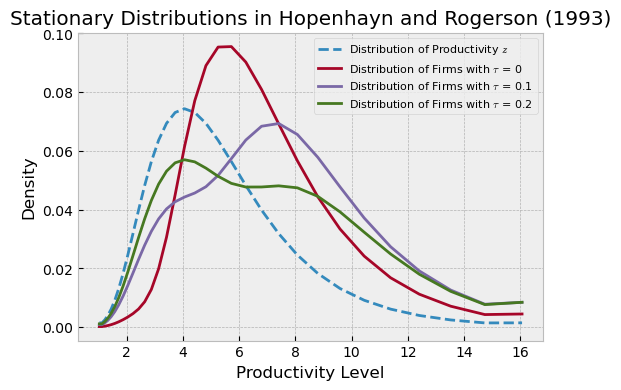

In [81]:
# Plotting invariant distributions of productivity and incumbent firms
plt.figure(figsize=(6, 4))
plt.plot(state_grid_shock, stationary_dist_shocks, 
         linestyle='--',
         label=fr'Distribution of Productivity $z$')

plt.plot(state_grid_shock, stationary_pmf_tau0, 
         label=fr'Distribution of Firms with $\tau$ = {tau_values[0]}')

plt.plot(state_grid_shock, stationary_pmf_tau1, 
         label=fr'Distribution of Firms with $\tau$ = {tau_values[1]}')

plt.plot(state_grid_shock, stationary_pmf_tau2, 
         label=fr'Distribution of Firms with $\tau$ = {tau_values[2]}')

# Adding labels and title
plt.title('Stationary Distributions in Hopenhayn and Rogerson (1993)')
plt.xlabel('Productivity Level')
plt.ylabel('Density')
plt.legend(loc='upper right', fontsize=8)

# Show the plot
plt.show()

With higher values of $\tau$, we have an increase in the mass of firms that are more productive, as they are the ones who can afford to stay in the market despite the firing costs.
This does not seem to hold with $\tau = 0.2$, though...

We see a lump for $\tau = .1$ and $\tau = .2$ around the value of 3.72, which is the $z^*$ of the benchmark model.

#### Value Function and Exit Rule

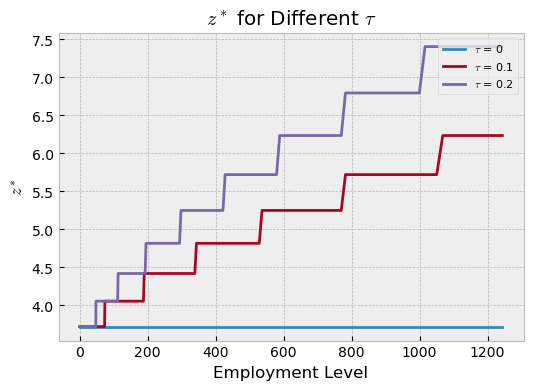

In [82]:
# Plotting exit decision
plt.figure(figsize=(6, 4))

plt.plot(employment_grid, solutions_dict_array[.0]['z_star'], 
         label=fr'$\tau$ = {tau_values[0]}')

plt.plot(employment_grid, solutions_dict_array[.1]['z_star'], 
         label=fr'$\tau$ = {tau_values[1]}')

plt.plot(employment_grid, solutions_dict_array[.2]['z_star'], 
         label=fr'$\tau$ = {tau_values[2]}')

# Adding labels and title
plt.title(fr'$z^*$ for Different $\tau$')
plt.xlabel('Employment Level')
plt.ylabel(r'$z^*$')
plt.legend(loc='upper right', fontsize=8)

# Show the plot
plt.show()

Note that $z^*$ are higher for higher values of $\tau$: for higher firing costs, the firm has to be more productive in order for the adjustment to be worth it.
Moreover, only more productive firms that can endure this cost stay in the market.

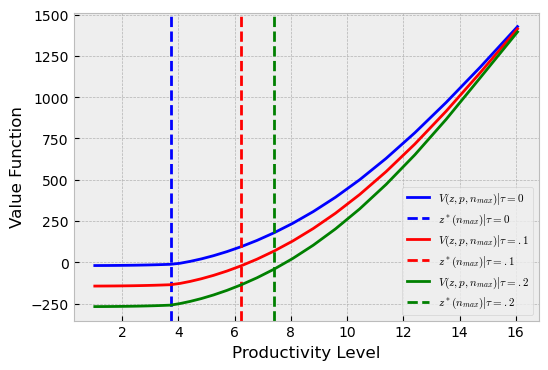

In [83]:
# Plotting exit decision
plt.figure(figsize=(6, 4))

plt.plot(state_grid_shock, solutions_dict_array[.0]['V'][:, -1], 
         label=r'$V(z, p, n_{max}) | \tau = 0$', color='b')

plt.axvline(x=solutions_dict_array[.0]['z_star'][-1],
            linestyle='--', color='b',
            label=r'$z^*(n_{max}) | \tau = 0$')

plt.plot(state_grid_shock, solutions_dict_array[.1]['V'][:, -1], 
         label=r'$V(z, p, n_{max}) | \tau = .1$', color='r')

plt.axvline(x=solutions_dict_array[.1]['z_star'][-1],
            linestyle='--', color='r',
            label=r'$z^*(n_{max}) | \tau = .1$')

plt.plot(state_grid_shock, solutions_dict_array[.2]['V'][:, -1], 
         label=r'$V(z, p, n_{max}) | \tau = .2$', color='g')

plt.axvline(x=solutions_dict_array[.2]['z_star'][-1],
            linestyle='--', color='g',
            label=r'$z^*(n_{max}) | \tau = .2$')

# Adding labels and title
plt.xlabel('Productivity Level')
plt.ylabel("Value Function")
plt.legend(loc='best', fontsize=8)

# Show the plot
plt.show()

It is hard to see, but higher $\tau$ leads so that the cut-off happen not only at larger productivity levels, but the value function needs to be more negative: when exiting the market, the firm must pay the cost of firing everyone, so it may be worth it to keep operating even with a negative value.

This may explain the fact that the firm distribution with $\tau = 2$ is not what we expect: firms may hinder their growth in order to avoid the larger firing costs that would come from exiting the market at a higher size.

#### Employment

In [84]:
# Calculating employment distribution
## Policy
policy_n_tau0 = solutions_dict_array[.0]['n']
policy_n_tau1 = solutions_dict_array[.1]['n']
policy_n_tau2 = solutions_dict_array[.2]['n']

## Aggregate employment
agg_n_tau0 = np.sum(policy_n_tau0 * stationary_distribution_tau0)
agg_n_tau1 = np.sum(policy_n_tau1 * stationary_distribution_tau1)
agg_n_tau2 = np.sum(policy_n_tau2 * stationary_distribution_tau2)

print(f"Aggregate employment with tau = {tau_values[0]}: {round(agg_n_tau0, 2)}")
print(f"Aggregate employment with tau = {tau_values[1]}: {round(agg_n_tau1, 2)}")
print(f"Aggregate employment with tau = {tau_values[2]}: {round(agg_n_tau2, 2)}")

Aggregate employment with tau = 0: 66.66
Aggregate employment with tau = 0.1: 65.83
Aggregate employment with tau = 0.2: 64.83


We see that aggregate employment falls with increased firing costs: firms can't hire as much as they want due to these costs, and so have to be cautious.

In [85]:
# Calculating pmfs
stationary_n_pmf_tau0 = np.sum(policy_n_tau0 * stationary_distribution_tau0, axis=1) / agg_n_tau0
stationary_n_pmf_tau1 = np.sum(policy_n_tau1 * stationary_distribution_tau1, axis=1) / agg_n_tau1
stationary_n_pmf_tau2 = np.sum(policy_n_tau2 * stationary_distribution_tau2, axis=1) / agg_n_tau2

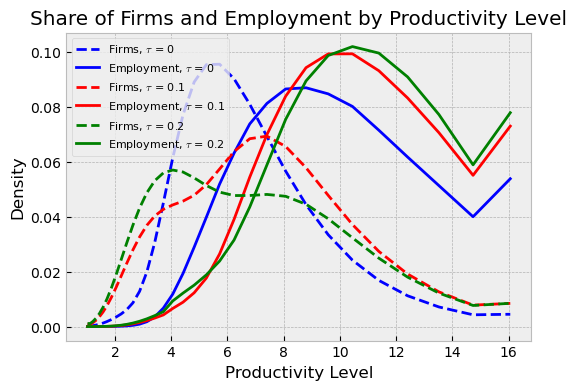

In [86]:
# Plotting distributions of firms and employment
plt.figure(figsize=(6, 4))

plt.plot(state_grid_shock, stationary_pmf_tau0, 
         color='b', linestyle='--',
         label=fr'Firms, $\tau$ = {tau_values[0]}')
plt.plot(state_grid_shock, stationary_n_pmf_tau0, color='b',
         label=fr'Employment, $\tau$ = {tau_values[0]}')

plt.plot(state_grid_shock, stationary_pmf_tau1, 
         color='r', linestyle='--',
         label=fr'Firms, $\tau$ = {tau_values[1]}')
plt.plot(state_grid_shock, stationary_n_pmf_tau1, color='r',
         label=fr'Employment, $\tau$ = {tau_values[1]}')

plt.plot(state_grid_shock, stationary_pmf_tau2, 
         color='g', linestyle='--',
         label=fr'Firms, $\tau$ = {tau_values[2]}')
plt.plot(state_grid_shock, stationary_n_pmf_tau2, color='g',
         label=fr'Employment, $\tau$ = {tau_values[2]}')

# Adding labels and title
plt.title(f'Share of Firms and Employment by Productivity Level')
plt.xlabel('Productivity Level')
plt.ylabel('Density')
plt.legend(loc='best', fontsize=8)

# Show the plot
plt.show()

A lot going on this plot: it is useful to just look at employment.

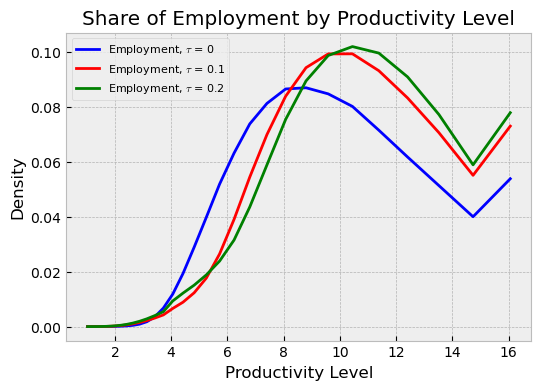

In [87]:
# Plotting distributions of employment
plt.figure(figsize=(6, 4))

plt.plot(state_grid_shock, stationary_n_pmf_tau0, color='b',
         label=fr'Employment, $\tau$ = {tau_values[0]}')

plt.plot(state_grid_shock, stationary_n_pmf_tau1, color='r',
         label=fr'Employment, $\tau$ = {tau_values[1]}')

plt.plot(state_grid_shock, stationary_n_pmf_tau2, color='g',
         label=fr'Employment, $\tau$ = {tau_values[2]}')

# Adding labels and title
plt.title(f'Share of Employment by Productivity Level')
plt.xlabel('Productivity Level')
plt.ylabel('Density')
plt.legend(loc='best', fontsize=8)

# Show the plot
plt.show()

With firing costs, we have an increase in the share of employment that is due to bigger (more productive) firms, which is consistent with the increase in average firm size documented by Hopenhayn and Rogerson (1993).

This is monotone in $\tau$, that is, $\tau = .2$ induces higher concentration of employment on larger firms than $\tau = .1$.

### Lumpy Adjustment and Inaction Region

Our adjustment cost is linear in the firing term: $g(n_t, n_{t-1}) = \tau \cdot \max \{ 0, n_{t - 1} - n_t \}$.

This can produce the fact that the firm may not find optimal to re-adjust labor even if its $z$ has changed.
We thus have an inaction region:

$$
n(z, n) = n_{t - 1} = n_t \text{ if } n \in \left( n_L(z), n_H(z) \right)
$$

In [88]:
# Getting optimal policy indexes of hiring decision
optimal_indexes_tau0 = solutions_dict_array[.0]['optimal_indexes']
optimal_indexes_tau1 = solutions_dict_array[.1]['optimal_indexes']
optimal_indexes_tau2 = solutions_dict_array[.2]['optimal_indexes']

In [89]:
# Auxiliary
mid_grid = np.floor(num_states_employment / 2)
employment_indexes = np.tile(np.arange(num_states_employment), (num_shocks, 1))

In [90]:
# Determining inaction region (optimal index = current index)
## This gives a binary matrix of where we have inaction; we still need to determine values
inaction_array_tau0 = (optimal_indexes_tau0 == employment_indexes).astype(int)
inaction_array_tau1 = (optimal_indexes_tau1 == employment_indexes).astype(int)
inaction_array_tau2 = (optimal_indexes_tau2 == employment_indexes).astype(int)

inaction_arrays = np.array([inaction_array_tau0, inaction_array_tau1, inaction_array_tau2])

In [91]:
# Determining inaction values (n_L and n_H)
## Skeletons
inaction_boundary_values_tau0 = np.zeros([num_shocks, 2])
inaction_boundary_values_tau1 = np.zeros([num_shocks, 2])
inaction_boundary_values_tau2 = np.zeros([num_shocks, 2])

inaction_boundary_arrays = np.array([inaction_boundary_values_tau0, 
                                     inaction_boundary_values_tau1,
                                     inaction_boundary_values_tau2])

## Looping
for i, inaction_array in enumerate(inaction_arrays):
    for index_shock in range(num_shocks):
        # Finding lowest values of inaction (nL)
        index_nl = np.argmax(inaction_array[index_shock] == 1)

        # Finding highest values of inaction (nH)
        ## [::-1] sorts the array in reverse order
        index_nh = num_states_employment - np.argmax(inaction_array[index_shock][::-1] == 1) - 1

        # Filling arrays
        inaction_boundary_arrays[i][index_shock, 0] = employment_grid[index_nl]
        inaction_boundary_arrays[i][index_shock, 1] = employment_grid[index_nh]

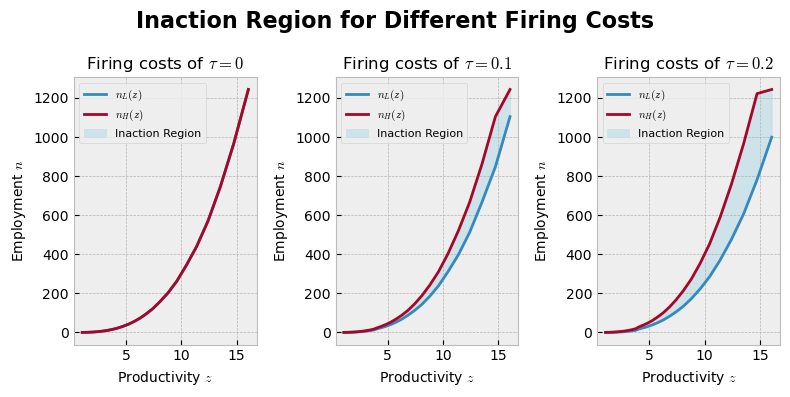

In [92]:
# Create a figure and axes for the 3x1 grid
fig, axes = plt.subplots(1, 3, figsize=(8, 4))  # Adjust figsize as necessary

# Loop over each array to plot in a different grid
for i, data in enumerate(inaction_boundary_arrays):
    ax = axes[i]

    # Grabbing values for boundaries
    nl_vector = data[:, 0]
    nh_vector = data[:, 1]
    
    # Plot first column as one line, second column as another line
    ax.plot(state_grid_shock, nl_vector, label=r'$n_L(z)$')
    ax.plot(state_grid_shock, nh_vector, label=r'$n_H(z)$')

    # Shade region between the two lines
    ax.fill_between(state_grid_shock, nl_vector, nh_vector, 
                    color='lightblue', alpha=0.5,
                    label='Inaction Region')
    
    # Add labels and title
    ax.set_xlabel(r'Productivity $z$', fontsize=10)
    ax.set_ylabel(r'Employment $n$', fontsize=10)
    ax.set_title(fr'Firing costs of $\tau = {tau_values[i]}$', fontsize=12)
    
    # Add legend
    ax.legend(loc='best', fontsize=8)

plt.suptitle("Inaction Region for Different Firing Costs", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Misallocation and Marginal Product of Labor

As we saw in class, in the model with $\tau = 0$ the marginal productivity of labor equalizes across firms:

$$
z \cdot \alpha n^{\alpha - 1} = \frac{1}{p}
$$

since $w = 1$ (numeraire).

In the model with adjustment costs, this need not be the case...

In [93]:
def marginal_productivity_labor(policy_n, z, param_dict):
    """
    Calculates marginal productivity of labor.
    """
    # Parameters
    alpha = param_dict['alpha']
    num_shocks = policy_n.shape[0]
    num_states = policy_n.shape[1]

    # Skeleton
    mp_array = np.empty_like(policy_n)

    # Looping to fill
    for index_shock in range(num_shocks):
        for index_state in range(num_states):
            mp_array[index_shock, index_state] = z[index_shock] * alpha * policy_n[index_shock, index_state]**(alpha - 1)

    return mp_array

In [94]:
# Calculating marginal productivities
mp_tau0 = marginal_productivity_labor(
    policy_n=solutions_dict_array[.0]['n'],
    z=state_grid_shock,
    param_dict=param_dict
)

mp_tau1 = marginal_productivity_labor(
    policy_n=solutions_dict_array[.1]['n'],
    z=state_grid_shock,
    param_dict=param_dict
)

mp_tau2 = marginal_productivity_labor(
    policy_n=solutions_dict_array[.2]['n'],
    z=state_grid_shock,
    param_dict=param_dict
)

In [95]:
# Calculating average misallocation
p_tau0 = solutions_dict_array[.0]['p']
avg_misalloc_tau0 = 100 * np.sum(np.abs(mp_tau0 - 1 / p_tau0) / (1 / p_tau0) * stationary_distribution_tau0) / np.sum(stationary_distribution_tau0)

p_tau1 = solutions_dict_array[.1]['p']
avg_misalloc_tau1 = 100 * np.sum(np.abs(mp_tau1 - 1 / p_tau1) / (1 / p_tau1) * stationary_distribution_tau1) / np.sum(stationary_distribution_tau1)

p_tau2 = solutions_dict_array[.2]['p']
avg_misalloc_tau2 = 100 * np.sum(np.abs(mp_tau2 - 1 / p_tau2) / (1 / p_tau2) * stationary_distribution_tau2) / np.sum(stationary_distribution_tau2)

In [96]:
# Printing
print(f"Average Misallocation for tau = {tau_values[0]}: {round(avg_misalloc_tau0, 1)}%")
print(f"Average Misallocation for tau = {tau_values[1]}: {round(avg_misalloc_tau1, 1)}%")
print(f"Average Misallocation for tau = {tau_values[2]}: {round(avg_misalloc_tau2, 1)}%")

Average Misallocation for tau = 0: 0.1%
Average Misallocation for tau = 0.1: 5.2%
Average Misallocation for tau = 0.2: 10.1%


We see that higher values of $\tau$ increase misallocation, in the sense that firms don't equate marginal productivity of labor to $\frac{1}{p}$.
This is due to them not adjusting their labor demands due to the existence of firing costs.

The positive value for $\tau = 0$ comes from the grid approximation.

## (c) Increase in Demand

### Solutions

In [87]:
# Skeletons for solution dictionaries
solutions_dict_array_alt = dict(zip(tau_values, tau_values))

# Copying param_dict
param_dict_alt_firing_costs = param_dict_alt.copy()

In [88]:
# Looping across tau values
## Time
t0_iterations_tau = time.time()

## Benchmark values
print(f"For benchmark with static labor decision and tau = 0:")
print(f"Free-entry p = {round(p_market_clearing_alt, 6)}")
print(f"Market clearing m = {round(m_market_clearing_alt, 6)}")


for tau_value in tau_values:
    # Updating tau
    param_dict_alt_firing_costs['tau'] = tau_value
    print(f"\nSolving for tau = {param_dict_alt_firing_costs['tau']}")

    # Solving
    t0 = time.time()

    solutions_dict_array_alt[tau_value] = solve_hopenhayn_rogerson(
        n_space=employment_grid,
        shock_space=state_grid_shock,
        shock_transition_matrix=transition_matrix,
        entrant_distribution=entrant_productivity_distribution,
        param_dict=param_dict_alt_firing_costs,
        tol_vfi=1e-6, # lowering tolerance so that things are a bit faster
        tol_dist=1e-9
    )

    time_solution = time.time() - t0

    print(f"Took {round(time_solution / 60, 1)} minutes to solve.")

time_iteration_tau = time.time() - t0_iterations_tau
print(f"\nTook {round(time_iteration_tau / 60, 1)} minutes to solve for all taus.")

For benchmark with static labor decision and tau = 0:
Free-entry p = 1.004135
Market clearing m = 0.107267

Solving for tau = 0
Free-entry p = 1.004137
Market clearing m = 0.107277
Took 3.1 minutes to solve.

Solving for tau = 0.1
Free-entry p = 1.016793
Market clearing m = 0.357471
Took 2.2 minutes to solve.

Solving for tau = 0.2
Free-entry p = 1.026695
Market clearing m = 0.54749
Took 2.5 minutes to solve.

Took 7.9 minutes to solve for all taus.


### Distributions

#### Firms and Productivity

In [89]:
# Getting stationary distributions
stationary_distribution_tau0_alt = solutions_dict_array_alt[.0]['stationary_incumbent_distribution_matrix']
stationary_distribution_tau1_alt = solutions_dict_array_alt[.1]['stationary_incumbent_distribution_matrix']
stationary_distribution_tau2_alt = solutions_dict_array_alt[.2]['stationary_incumbent_distribution_matrix']

In [90]:
# Printing mass of operating firms
print(f"Mass of incumbent firms with tau = {tau_values[0]}: {round(np.sum(stationary_distribution_tau0_alt), 2)}")
print(f"Mass of incumbent firms with tau = {tau_values[1]}: {round(np.sum(stationary_distribution_tau1_alt), 2)}")
print(f"Mass of incumbent firms with tau = {tau_values[2]}: {round(np.sum(stationary_distribution_tau2_alt), 2)}")

Mass of incumbent firms with tau = 0: 0.77
Mass of incumbent firms with tau = 0.1: 0.62
Mass of incumbent firms with tau = 0.2: 0.72


In [91]:
# Calculating PMFs and CDFs
stationary_pmf_tau0_alt = np.sum(stationary_distribution_tau0_alt, axis=1) / np.sum(stationary_distribution_tau0_alt)
stationary_pmf_tau1_alt = np.sum(stationary_distribution_tau1_alt, axis=1) / np.sum(stationary_distribution_tau1_alt)
stationary_pmf_tau2_alt = np.sum(stationary_distribution_tau2_alt, axis=1) / np.sum(stationary_distribution_tau2_alt)

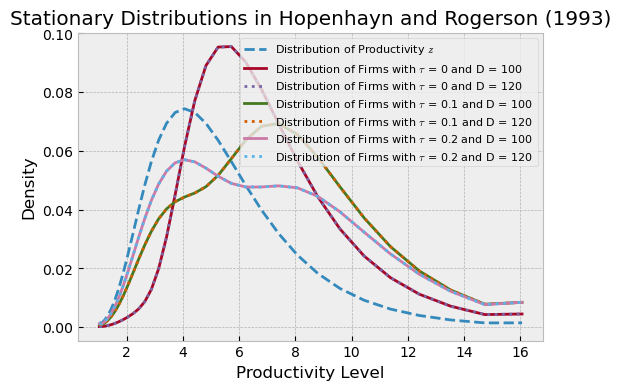

In [92]:
# Plotting invariant distributions of productivity and incumbent firms
plt.figure(figsize=(6, 4))
plt.plot(state_grid_shock, stationary_dist_shocks, 
         linestyle='--',
         label=fr'Distribution of Productivity $z$')

plt.plot(state_grid_shock, stationary_pmf_tau0, 
         label=fr'Distribution of Firms with $\tau$ = {tau_values[0]} and D = {demand_constant}')
plt.plot(state_grid_shock, stationary_pmf_tau0_alt, 
         linestyle='dotted',
         label=fr'Distribution of Firms with $\tau$ = {tau_values[0]} and D = {demand_constant_alt}')

plt.plot(state_grid_shock, stationary_pmf_tau1, 
         label=fr'Distribution of Firms with $\tau$ = {tau_values[1]} and D = {demand_constant}')
plt.plot(state_grid_shock, stationary_pmf_tau1_alt, 
         linestyle='dotted',
         label=fr'Distribution of Firms with $\tau$ = {tau_values[1]} and D = {demand_constant_alt}')

plt.plot(state_grid_shock, stationary_pmf_tau2, 
         label=fr'Distribution of Firms with $\tau$ = {tau_values[2]} and D = {demand_constant}')
plt.plot(state_grid_shock, stationary_pmf_tau2_alt, 
         linestyle='dotted',
         label=fr'Distribution of Firms with $\tau$ = {tau_values[2]} and D = {demand_constant_alt}')

# Adding labels and title
plt.title('Stationary Distributions in Hopenhayn and Rogerson (1993)')
plt.xlabel('Productivity Level')
plt.ylabel('Density')
plt.legend(loc='upper right', fontsize=8)

# Show the plot
plt.show()

The distribution of firms are the same, despite the increase in the measure of entrants $m$.
Note also that $\chi$ is determined in the price-finding process, so it is also the same.

This is exactly because the parameters determining the firms' "survival" didn't change: we can have more entrants, but the distribution of those that stay in the economy are exactly the same.

#### Employment

In [93]:
# Calculating employment distribution
## Policy
policy_n_tau0_alt = solutions_dict_array_alt[.0]['n']
policy_n_tau1_alt = solutions_dict_array_alt[.1]['n']
policy_n_tau2_alt = solutions_dict_array_alt[.2]['n']

## Aggregate employment
agg_n_tau0_alt = np.sum(policy_n_tau0_alt * stationary_distribution_tau0_alt)
agg_n_tau1_alt = np.sum(policy_n_tau1_alt * stationary_distribution_tau1_alt)
agg_n_tau2_alt = np.sum(policy_n_tau2_alt * stationary_distribution_tau2_alt)

print(f"Aggregate employment with D = {demand_constant} and tau = {tau_values[0]}: {round(agg_n_tau0, 2)}")
print(f"Aggregate employment with D = {demand_constant} and tau = {tau_values[1]}: {round(agg_n_tau1, 2)}")
print(f"Aggregate employment with D = {demand_constant} and tau = {tau_values[2]}: {round(agg_n_tau2, 2)}")

print(f"\nAggregate employment with D = {demand_constant_alt} and tau = {tau_values[0]}: {round(agg_n_tau0_alt, 2)}")
print(f"Aggregate employment with D = {demand_constant_alt} and tau = {tau_values[1]}: {round(agg_n_tau1_alt, 2)}")
print(f"Aggregate employment with D = {demand_constant_alt} and tau = {tau_values[2]}: {round(agg_n_tau2_alt, 2)}")

Aggregate employment with D = 100 and tau = 0: 66.66
Aggregate employment with D = 100 and tau = 0.1: 65.83
Aggregate employment with D = 100 and tau = 0.2: 64.83

Aggregate employment with D = 120 and tau = 0: 80.0
Aggregate employment with D = 120 and tau = 0.1: 79.0
Aggregate employment with D = 120 and tau = 0.2: 77.8


In [94]:
# Calculating pmfs
stationary_n_pmf_tau0_alt = np.sum(policy_n_tau0_alt * stationary_distribution_tau0_alt, axis=1) / agg_n_tau0_alt
stationary_n_pmf_tau1_alt = np.sum(policy_n_tau1_alt * stationary_distribution_tau1_alt, axis=1) / agg_n_tau1_alt
stationary_n_pmf_tau2_alt = np.sum(policy_n_tau2_alt * stationary_distribution_tau2_alt, axis=1) / agg_n_tau2_alt

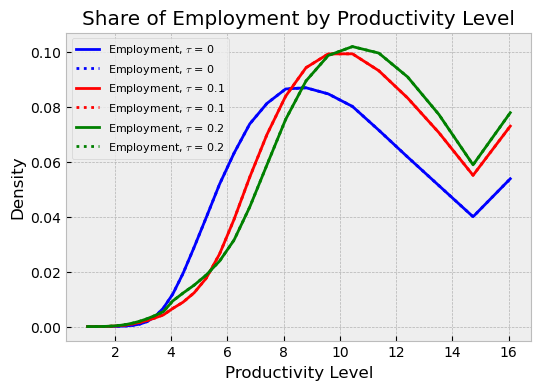

In [95]:
# Plotting distributions of employment
plt.figure(figsize=(6, 4))

plt.plot(state_grid_shock, stationary_n_pmf_tau0, color='b',
         label=fr'Employment, $\tau$ = {tau_values[0]}')
plt.plot(state_grid_shock, stationary_n_pmf_tau0_alt, 
         color='b', linestyle='dotted',
         label=fr'Employment, $\tau$ = {tau_values[0]}')

plt.plot(state_grid_shock, stationary_n_pmf_tau1, color='r',
         label=fr'Employment, $\tau$ = {tau_values[1]}')
plt.plot(state_grid_shock, stationary_n_pmf_tau1_alt, 
         color='r', linestyle='dotted',
         label=fr'Employment, $\tau$ = {tau_values[1]}')

plt.plot(state_grid_shock, stationary_n_pmf_tau2, color='g',
         label=fr'Employment, $\tau$ = {tau_values[2]}')
plt.plot(state_grid_shock, stationary_n_pmf_tau2_alt, 
         color='g', linestyle='dotted',
         label=fr'Employment, $\tau$ = {tau_values[2]}')

# Adding labels and title
plt.title(f'Share of Employment by Productivity Level')
plt.xlabel('Productivity Level')
plt.ylabel('Density')
plt.legend(loc='best', fontsize=8)

# Show the plot
plt.show()

Again, the distribution are the same: this is because $n(z, p)$ is determined in the price-finding process, and so does not depend on $m$.